In [1]:
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

from data.data_generators import *
import torch


def get_available_gpu_with_most_memory():
    gpu_memory = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch to the GPU to accurately measure memory
        gpu_memory.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
    
    gpu_memory.sort(key=lambda x: x[1], reverse=True)
    
    return gpu_memory[0][0]

if torch.cuda.is_available():
    available_gpu = get_available_gpu_with_most_memory()
    if available_gpu == 0:
        device_wta = torch.device("cuda:0")
        device_cnp = torch.device("cuda:0")
    else:
        device_wta = torch.device(f"cuda:{available_gpu}")
        device_cnp = torch.device(f"cuda:{available_gpu}")
else:
    device_wta = torch.device("cpu")
    device_cnp = torch.device("cpu")

print("Device WTA:", device_wta, "Device CNP:", device_cnp)

###

torch.set_float32_matmul_precision('high')

Device WTA: cpu Device CNP: cpu


/home/yigit/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
batch_size = 20
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 20
num_classes = 20
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 20
num_val_indiv = num_val//num_classes

colors = ['tomato', 'aqua', 'limegreen', 'gold', 'mediumslateblue', 'lightcoral', 'darkorange', 'teal']

X: torch.Size([20, 200, 1]) Y: torch.Size([20, 200, 1]) VX: torch.Size([20, 200, 1]) VY: torch.Size([20, 200, 1])


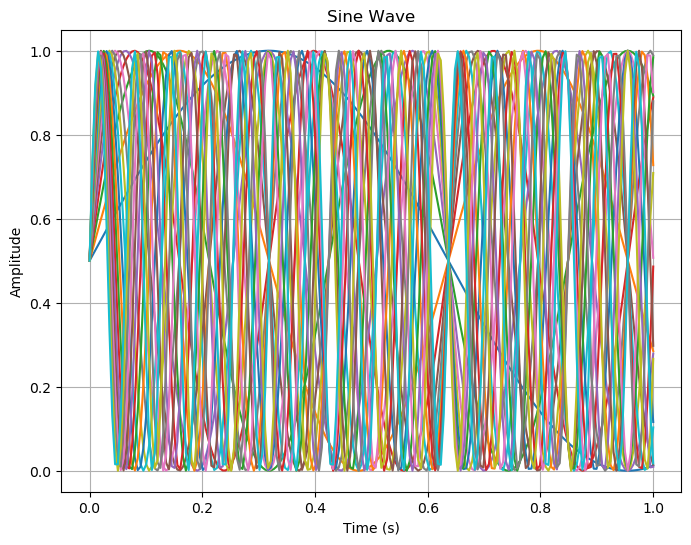

In [3]:
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
# dum_x = torch.linspace(0, 1, 220).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

for i in range(num_classes):
    start_ind = i*num_indiv
    coeff = (i+1)/2*torch.pi
    y[start_ind:start_ind+num_indiv] = (torch.unsqueeze(generate_sin(x*coeff), 2) +1)/2.0

    noise = torch.unsqueeze(torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip, -1)

    start_ind = i*num_val_indiv
    vy[start_ind:start_ind+num_indiv] = y[start_ind:start_ind+num_indiv].clone() + noise  # num_indiv = num_val_indiv

# coeff = 2*torch.pi
# y[:num_indiv] = torch.unsqueeze(generate_sin(x*coeff), 2)
# coeff = torch.pi
# y[num_indiv:] = torch.unsqueeze(generate_sin(x*coeff), 2)

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(num_demos):
    plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), label=f'Sine Wave {i+1}')
    # plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)

# plt.legend()
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Sine Wave')

x0, y0 = x.to(device_wta), y.to(device_wta)
x1, y1 = x.to(device_cnp), y.to(device_cnp)

In [4]:
def get_batch(x, y, traj_ids, device=device_wta):
    n_o = torch.randint(1, n_max_obs, (1,)).item()
    n_t = torch.randint(1, n_max_tar, (1,)).item()
    
    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)
    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val

def get_validation_batch(vx, vy, traj_ids, device=device_wta):
    num_obs = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, num_obs, dx+dy, device=device)
    tar = torch.zeros(batch_size, t_steps, dx, device=device)
    tar_val = torch.zeros(batch_size, t_steps, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:num_obs]

        obs[i, :, :] = torch.cat((vx[traj_ids[i], o_ids], vy[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = vx[traj_ids[i]]
        tar_val[i, :, :] = vy[traj_ids[i]]

    return obs, tar, tar_val

In [5]:
model_wta_ = WTA_CNP(1, 1, n_max_obs, n_max_tar, [1024,1024,1024], num_decoders=20, decoder_hidden_dims=[256, 256, 256], batch_size=batch_size, scale_coefs=True).to(device_wta)
optimizer_wta = torch.optim.Adam(lr=1e-4, params=model_wta_.parameters())

model_cnp_ = CNP(input_dim=1, hidden_dim=1205, output_dim=1, n_max_obs=n_max_obs, n_max_tar=n_max_tar, num_layers=4, batch_size=batch_size).to(device_cnp)
optimizer_cnp = torch.optim.Adam(lr=1e-4, params=model_cnp_.parameters())

# print("WTA Model:", model_wta)

In [6]:
def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("WTA-CNP:", get_parameter_count(model_wta_))
print("CNP:", get_parameter_count(model_cnp_))

if torch.__version__ >= "2.0":
    model_cnp, model_wta = torch.compile(model_cnp_), torch.compile(model_wta_)

WTA-CNP: 8702012
CNP: 8726612


In [7]:
from matplotlib.lines import Line2D


def draw_val_plot(root_folder, epoch):
    plt_y_lim = torch.max(vy) + 0.1

    obs = torch.zeros((model_wta.num_decoders, 1, 1, 2)).to(device_wta)
    for i in range(batch_size):
        obs[i] = torch.Tensor([x[i, 80, 0], y[i, 80, 0]]).unsqueeze(0).unsqueeze(0).to(device_wta)

    tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).to(device_wta)

    with torch.no_grad():
        for i in range(batch_size):
            pred_cnp, _ = model_cnp(obs[i], tar)
            pred_wta, gate = model_wta(obs[i], tar)

            plt.ylim((-plt_y_lim, plt_y_lim))
            plt.scatter(obs[i,:,:,0].cpu(), obs[i,:,:,1].cpu(), c='k')
            for j in range(batch_size):
                plt.plot(torch.linspace(0, 1, 200), pred_wta[j,0,:,0].cpu(), colors[j], alpha=max(0.2, gate[0, 0, j].item()))  # wta pred
            plt.plot(torch.linspace(0, 1, 200), pred_cnp[:, :, :model_cnp.output_dim].squeeze(0).cpu(), 'b')  # cnp pred
            handles = []
            for j in range(batch_size):
                plt.plot(torch.linspace(0, 1, 200), vy[j].squeeze(-1).cpu(), 'k', alpha=0.05 if j!=i else 0.35)  # data
                handles.append(Line2D([0], [0], label=f'gate{j}: {gate[0, 0, j].item():.4f}', color=colors[j]))

            plt.legend(handles=handles, loc='upper right')

            plt.savefig(f'{root_folder}img/{i}_{epoch}.png')
            plt.close()

In [8]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/sine/20_sines/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 50_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss_wta, avg_loss_cnp = 0, 0

val_per_epoch = 1000
min_val_loss_wta, min_val_loss_cnp = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

training_loss_wta, validation_error_wta = [], []
training_loss_cnp, validation_error_cnp = [], []

wta_tr_loss_path = f'{root_folder}wta_training_loss.pt'
wta_val_err_path = f'{root_folder}wta_validation_error.pt'
cnp_tr_loss_path = f'{root_folder}cnp_training_loss.pt'
cnp_val_err_path = f'{root_folder}cnp_validation_error.pt'

for epoch in range(epochs):
    epoch_loss_wta, epoch_loss_cnp = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer_wta.zero_grad()
        optimizer_cnp.zero_grad()

        obs_wta, tar_x_wta, tar_y_wta = get_batch(x, y, traj_ids[i], device_wta)
        obs_cnp, tar_x_cnp, tar_y_cnp = obs_wta.clone(), tar_x_wta.clone(), tar_y_wta.clone()

        pred_wta, gate_wta = model_wta(obs_wta, tar_x_wta)
        pred_cnp, encoded_rep_cnp = model_cnp(obs_cnp, tar_x_cnp)

        loss_wta, wta_nll = model_wta.loss(pred_wta, gate_wta, tar_y_wta)

        loss_wta.backward()
        optimizer_wta.step()

        loss_cnp = model_cnp.loss(pred_cnp, tar_y_cnp)
        loss_cnp.backward()
        optimizer_cnp.step()

        epoch_loss_wta += wta_nll.item()
        epoch_loss_cnp += loss_cnp.item()

    training_loss_wta.append(epoch_loss_wta)
    training_loss_cnp.append(epoch_loss_cnp)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss_wta, val_loss_cnp = 0, 0

            for j in range(v_epoch_iter):
                o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, v_traj_ids[j], device=device_wta)
                o_cnp, t_cnp, tr_cnp = o_wta.clone(), t_wta.clone(), tr_wta.clone()

                p_wta, g_wta = model_wta(o_wta, t_wta)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss_wta += mse_loss(vp_means, tr_wta).item()

                pred_cnp, encoded_rep = model_cnp(o_cnp, t_cnp)
                val_loss_cnp += mse_loss(pred_cnp[:, :, :model_cnp.output_dim], tr_cnp)


            validation_error_wta.append(val_loss_wta)
            if val_loss_wta < min_val_loss_wta:
                min_val_loss_wta = val_loss_wta
                print(f'(WTA)New best: {min_val_loss_wta}')
                torch.save(model_wta_.state_dict(), f'{root_folder}saved_models/wta_on_synth.pt')

            validation_error_cnp.append(val_loss_cnp.item())
            if val_loss_cnp < min_val_loss_cnp:
                min_val_loss_cnp = val_loss_cnp
                print(f'(CNP)New best: {min_val_loss_cnp}')
                torch.save(model_cnp_.state_dict(), f'{root_folder}saved_models/cnp_on_synth.pt')
  
        if epoch % (val_per_epoch*10) == 0:
            draw_val_plot(root_folder, epoch)


    avg_loss_wta += epoch_loss_wta
    avg_loss_cnp += epoch_loss_cnp

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, WTA-Loss: {}, CNP-Loss: {}".format(epoch, avg_loss_wta/val_per_epoch, avg_loss_cnp/val_per_epoch))
        avg_loss_wta, avg_loss_cnp = 0, 0

torch.save(torch.Tensor(training_loss_wta), wta_tr_loss_path)
torch.save(torch.Tensor(validation_error_wta), wta_val_err_path)
torch.save(torch.Tensor(training_loss_cnp), cnp_tr_loss_path)
torch.save(torch.Tensor(validation_error_cnp), cnp_val_err_path)

CppCompileError: C++ compile error

Command:
g++ /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp -shared -fPIC -Wall -std=c++17 -Wno-unused-variable -I/home/yigit/.local/lib/python3.8/site-packages/torch/include -I/home/yigit/.local/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -I/home/yigit/.local/lib/python3.8/site-packages/torch/include/TH -I/home/yigit/.local/lib/python3.8/site-packages/torch/include/THC -I/usr/include/python3.8 -L/home/yigit/.local/lib/python3.8/site-packages/torch/lib -L/usr/lib -lc10 -ltorch -ltorch_cpu -ltorch_python -lgomp -DCPU_CAPABILITY_AVX512 -O3 -ffast-math -fno-finite-math-only -march=native -fopenmp -D C10_USING_CUSTOM_GENERATED_MACROS -o/tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.so

Output:
In file included from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512.h:8,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec.h:4,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional_base.h:6,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional.h:3,
                 from /tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:10,
                 from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec_base.h:1011: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
 1011 | # pragma unroll
      | 
In file included from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512.h:9,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec.h:4,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional_base.h:6,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional.h:3,
                 from /tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:10,
                 from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_float.h:485: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  485 | #pragma unroll
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_float.h:489: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  489 | #pragma unroll
      | 
In file included from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512.h:10,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec.h:4,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional_base.h:6,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional.h:3,
                 from /tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:10,
                 from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:284: warning: ignoring #pragma clang diagnostic [-Wunknown-pragmas]
  284 |   #pragma clang diagnostic push
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:285: warning: ignoring #pragma clang diagnostic [-Wunknown-pragmas]
  285 |   #pragma clang diagnostic ignored "-Wignored-qualifiers"
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:293: warning: ignoring #pragma clang diagnostic [-Wunknown-pragmas]
  293 |   #pragma clang diagnostic pop
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:795: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  795 | #pragma unroll
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:800: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  800 | #pragma unroll
      | 
In file included from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512.h:11,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec.h:4,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional_base.h:6,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional.h:3,
                 from /tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:10,
                 from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_double.h:441: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  441 | #pragma unroll
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_double.h:445: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  445 | #pragma unroll
      | 
In file included from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512.h:12,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec.h:4,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional_base.h:6,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional.h:3,
                 from /tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:10,
                 from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_int.h:325: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  325 | # pragma unroll
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_int.h:333: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  333 | # pragma unroll
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_int.h:345: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  345 | # pragma unroll
      | 
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_int.h:353: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
  353 | # pragma unroll
      | 
In file included from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:66: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
   66 | #pragma unroll
      | 
/tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:75: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
   75 | #pragma unroll
      | 
/tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:88: warning: ignoring #pragma unroll  [-Wunknown-pragmas]
   88 | #pragma unroll
      | 
In file included from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512.h:10,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec.h:4,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional_base.h:6,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional.h:3,
                 from /tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:10,
                 from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In static member function ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&)’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:34: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:34: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:34: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:34: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:34: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:34: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:34: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:34: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:34: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:34: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:35: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:35: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:35: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:35: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:35: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:35: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:35: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:35: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:35: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:35: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:35: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:35: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
      |                                   ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:34: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
      |                                  ^
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:34: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
      |                                  ^
/tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp: In function ‘void kernel(const float*, const float*, float*, float*)’:
/tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:31:60: error: cannot convert ‘at::vec::CPU_CAPABILITY::Vectorized<int>’ to ‘const at::vec::CPU_CAPABILITY::Vectorized<float>&’
   31 |             auto tmp5 = decltype(tmp3)::blendv(tmp4, tmp3, tmp2);
      |                                                            ^~~~
      |                                                            |
      |                                                            at::vec::CPU_CAPABILITY::Vectorized<int>
In file included from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512.h:9,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec.h:4,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional_base.h:6,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional.h:3,
                 from /tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:10,
                 from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_float.h:50:56: note:   initializing argument 3 of ‘static at::vec::CPU_CAPABILITY::Vectorized<float> at::vec::CPU_CAPABILITY::Vectorized<float>::blendv(const at::vec::CPU_CAPABILITY::Vectorized<float>&, const at::vec::CPU_CAPABILITY::Vectorized<float>&, const at::vec::CPU_CAPABILITY::Vectorized<float>&)’
   50 |                               const Vectorized<float>& mask) {
      |                               ~~~~~~~~~~~~~~~~~~~~~~~~~^~~~
In file included from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512.h:10,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec.h:4,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional_base.h:6,
                 from /home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/functional.h:3,
                 from /tmp/torchinductor_yigit/zt/cztcl2vp5yqlnhofzpqfficjcxgyict6e3xhfdd7sdbkipp4p44x.h:10,
                 from /tmp/torchinductor_yigit/xx/cxxuu3awmm46lniuq3jj6ee5dvm3uvhhptjop77waxu4j5c6vsi7.cpp:2:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 1]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:220:29:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 3]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:222:29:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 7]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:224:29:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 15]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:226:30:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 31]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:228:30:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 63]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:230:30:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 127]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:232:31:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 255]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:234:31:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 511]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:236:31:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 1023]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:238:32:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 2047]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:240:32:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 4095]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:242:32:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 8191]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:244:32:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 16383]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:246:33:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 32767]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:248:33:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 65535]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:250:33:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 131071]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:252:34:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 262143]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:254:34:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 524287]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:256:34:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 1048575]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:258:35:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 2097151]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:260:35:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 4194303]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:262:35:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 8388607]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:264:35:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 16777215]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:266:36:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 33554431]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:268:36:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 67108863]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:270:36:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 134217727]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:272:37:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 268435455]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:274:37:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 536870911]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:276:37:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 1073741823]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:278:38:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h: In instantiation of ‘static at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16> at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>::blend(const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&, const at::vec::CPU_CAPABILITY::Vectorized<c10::BFloat16>&) [with long int mask = 2147483647]’:
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:280:38:   required from here
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:131:21: warning: index value is out of bound [-Warray-bounds]
  131 |       tmp_values[0] = b.values[31];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:133:21: warning: index value is out of bound [-Warray-bounds]
  133 |       tmp_values[1] = b.values[30];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:135:21: warning: index value is out of bound [-Warray-bounds]
  135 |       tmp_values[2] = b.values[29];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:137:21: warning: index value is out of bound [-Warray-bounds]
  137 |       tmp_values[3] = b.values[28];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:139:21: warning: index value is out of bound [-Warray-bounds]
  139 |       tmp_values[4] = b.values[27];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:141:21: warning: index value is out of bound [-Warray-bounds]
  141 |       tmp_values[5] = b.values[26];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:143:21: warning: index value is out of bound [-Warray-bounds]
  143 |       tmp_values[6] = b.values[25];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:145:21: warning: index value is out of bound [-Warray-bounds]
  145 |       tmp_values[7] = b.values[24];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:147:21: warning: index value is out of bound [-Warray-bounds]
  147 |       tmp_values[8] = b.values[23];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:149:21: warning: index value is out of bound [-Warray-bounds]
  149 |       tmp_values[9] = b.values[22];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:151:22: warning: index value is out of bound [-Warray-bounds]
  151 |       tmp_values[10] = b.values[21];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:153:22: warning: index value is out of bound [-Warray-bounds]
  153 |       tmp_values[11] = b.values[20];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:155:22: warning: index value is out of bound [-Warray-bounds]
  155 |       tmp_values[12] = b.values[19];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:157:22: warning: index value is out of bound [-Warray-bounds]
  157 |       tmp_values[13] = b.values[18];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:159:22: warning: index value is out of bound [-Warray-bounds]
  159 |       tmp_values[14] = b.values[17];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:161:22: warning: index value is out of bound [-Warray-bounds]
  161 |       tmp_values[15] = b.values[16];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:163:22: warning: index value is out of bound [-Warray-bounds]
  163 |       tmp_values[16] = b.values[15];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:165:22: warning: index value is out of bound [-Warray-bounds]
  165 |       tmp_values[17] = b.values[14];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:167:22: warning: index value is out of bound [-Warray-bounds]
  167 |       tmp_values[18] = b.values[13];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:169:22: warning: index value is out of bound [-Warray-bounds]
  169 |       tmp_values[19] = b.values[12];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:171:22: warning: index value is out of bound [-Warray-bounds]
  171 |       tmp_values[20] = b.values[11];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:173:22: warning: index value is out of bound [-Warray-bounds]
  173 |       tmp_values[21] = b.values[10];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:175:22: warning: index value is out of bound [-Warray-bounds]
  175 |       tmp_values[22] = b.values[9];
/home/yigit/.local/lib/python3.8/site-packages/torch/include/ATen/cpu/vec/vec512/vec512_bfloat16.h:177:22: warning: index value is out of bound [-Warray-bounds]
  177 |       tmp_values[23] = b.values[8];


In [ ]:
open(f'{root_folder}fin', 'w').close()